In [ ]:
#%pip install ipympl
#%matplotlib ipympl 



try:
  import matplotlib.pyplot as plt
  from qiskit.quantum_info import partial_trace,Statevector
  import qiskit 
  from qiskit_aer.noise import NoiseModel, pauli_error
  from qiskit_aer import AerSimulator
  from qiskit import transpile
except:
  !pip install matplotlib qiskit[visualization] qiskit_aer
  import matplotlib.pyplot as plt
  from qiskit.quantum_info import partial_trace,Statevector
  import qiskit 
  from qiskit_aer.noise import NoiseModel, pauli_error
  from qiskit_aer import AerSimulator
  from qiskit import transpile

### helper stuff 
def pauli_error_x(err, _):
    return pauli_error([('I', 1 - err), ('X', err)])


def pauli_error_z(err, _):
    return pauli_error([('I', 1 - err), ('Z', err)])

def pauli_error_y(err, _):
    return pauli_error([('I', 1 - err), ('Y', err)])

def run_with_error(qc, id_error, shots=100, opt_level=0):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(id_error, 'id')
    sim = AerSimulator(method='matrix_product_state', noise_model=noise_model)
    # sim = Aer.get_backend('qasm_simulator')

    transpiled_qc = transpile(qc, sim, optimization_level=opt_level)
    res = sim.run(transpiled_qc, shots=shots).result()
    return res



def test_quantum_qec(qc_enc: qiskit.QuantumCircuit | None = None, qc_syndrome: qiskit.QuantumCircuit | None = None,
                     qc_correct: qiskit.QuantumCircuit | None = None,
                     qc_decode: qiskit.QuantumCircuit | None = None, qc_type=0):
    # 0: bitlfip
    # 1: phaseflip
    # 2: shor
    pad_bits = 4
    err_to_apply = qiskit.circuit.library.IGate
    err_model = pauli_error_x
    channe_qbits = 3
    if qc_type == 0:
        err_to_apply = qiskit.circuit.library.XGate
    elif qc_type == 1:
        err_to_apply = qiskit.circuit.library.ZGate
        err_model = pauli_error_z
    elif qc_type == 2:
        pad_bits = 16
        err_to_apply = qiskit.circuit.library.YGate
        channe_qbits = 9
        err_model = pauli_error_y

    sv = None
    sv_res = None
    failed = False

    for i in range(channe_qbits):
        sv = qiskit.quantum_info.random_statevector(2, seed=209)
        sv = sv.from_label("0" * pad_bits).tensor(sv)

        qc = qiskit.QuantumCircuit(qc_enc.num_qubits)
        qc.compose(qc_enc, inplace=True, wrap=True)

        qc.append(err_to_apply(), qargs=[i])

        qc.barrier(label="Errors")

        if qc_syndrome:
            qc.compose(qc_syndrome, inplace=True, wrap=True)

        if qc_correct:
            qc.compose(qc_correct, inplace=True, wrap=True)


        if qc_decode:
            qc.compose(qc_decode, inplace=True, wrap=True)

        #qc.draw("mpl")

        sv_res = sv.evolve(qc)
        sv = partial_trace(sv, [i for i in range(1, pad_bits + 1)])
        sv_res = partial_trace(sv_res, [i for i in range(1, pad_bits + 1)])

        if sv == sv_res:
            continue
        failed = True
        print(f"Error when applying error to the {i}th channel bit!")

    if failed:
        return 
        
    print("Your QEC is working as intended congratulations!")
    qc = qiskit.QuantumCircuit(qc_enc.num_qubits,1)
    
    
    
    qc.x(0)
    
    qc.compose(qc_enc, inplace=True, wrap=True)

    for i in range(channe_qbits):
        qc.id(i)

    qc.barrier(label="Errors")

    if qc_syndrome:
        qc.compose(qc_syndrome, inplace=True, wrap=True)

    if qc_correct:
        qc.compose(qc_correct, inplace=True, wrap=True)

    if qc_decode:
        qc.compose(qc_decode, inplace=True, wrap=True)
        
    qc.measure(0,0)
    
    fids = []
    errs = []
    n= 50
    for k in range(n):
        max_err=  0.5
        use_err = k/n*max_err
        results = run_with_error(qc,id_error=err_model(use_err,None))
        try:
            fidelity = results.get_counts()["1"]/100
        except:
            fidelity =0
        
        fids.append(fidelity)
        errs.append(use_err)
    
    
    plt.xlabel('Error chance')
    plt.ylabel('Fidelity')
    plt.plot(errs,fids)


# Creating code to correct a simple bit-flip error
### Encoding:

Create a quantum circuit that encodes the input quantum bit into the desired logical state:

$|\phi> = \alpha|0> +\beta|1>$ -> $\alpha|000> +\beta|111>$
 
 

In [ ]:
channel = qiskit.QuantumRegister(3)
ancillas = qiskit.QuantumRegister(2)
qc_encode = qiskit.QuantumCircuit(channel,ancillas,name="enc")

### Your code goes here



###
qc_encode.draw("mpl")


### Using the StateVector object test your code!

In [ ]:

sv_res = ...

###
sv_res.draw("Latex")

### Error detection 

Create a quantum circuit that projects the errors into the ancilla quantum bits.

### Help:
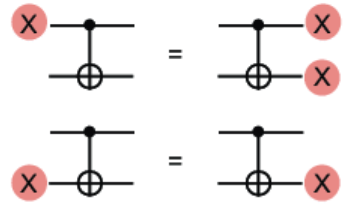

In [ ]:
channel = qiskit.QuantumRegister(3)
ancillas = qiskit.QuantumRegister(2)
qc_shor_bit = qiskit.QuantumCircuit(channel, ancillas, name="syn")

### Your code goes here


###
qc_shor_bit.draw("mpl")



### Using the StateVector object test your code!

In [ ]:

sv_res = ...

###
sv_res.draw("Latex")

### Correcting errors 
Create a quantum circuit that with the use of ancilla quantum bits corrects the errors!

### Help
the CCX gate can be used as an indexing function

If you want it to activate for only set '10' use X gate on the second ancilla or with the ctrl_state parameter

In [ ]:
channel = qiskit.QuantumRegister(3)
ancillas = qiskit.QuantumRegister(2)
qc_correct = qiskit.QuantumCircuit(channel,ancillas,name="corr")

### Your code goes here


###
qc_correct.draw("mpl")

### Using the StateVector object test your code!


In [ ]:

sv_res = ...

###
sv_res.draw("Latex")

### Decode

Create a quanum circuit that tranforms back the logical state in to the original 1 quantum bit state!

$|\phi> = \alpha|0> +\beta|1>$

In [ ]:
channel = qiskit.QuantumRegister(3)
ancillas = qiskit.QuantumRegister(2)
qc_decode = qiskit.QuantumCircuit(channel,ancillas,name="dec")

### Your code goes here


###
qc_decode.draw("mpl")

### Using the StateVector object test your code!

In [ ]:

sv_res = ...

###
sv_res.draw("Latex")

### And we are done! 

Use the following code to test your solution!
 

In [ ]:
#Qecc test
plt.close()
test_quantum_qec(qc_enc=qc_encode, qc_syndrome=qc_shor_bit, qc_correct=qc_correct, qc_decode=qc_decode, qc_type=0)


### Congrats! Using the circuits created until now create a phase-flip (Z) error correcting circuit!

##### Hint:
Phase-flip errors can be transformed into bitflip errors using a Hadamard gate!



In [ ]:
ph_enc = qc_encode.copy()
ph_syn = qc_shor_bit.copy()
ph_cor = qc_correct.copy()
ph_dec = qc_decode.copy()

### Your code goes here


###
qc_ph = qiskit.QuantumCircuit(ph_enc.num_qubits)
qc_ph.compose(ph_enc, inplace=True)
qc_ph.barrier(label="encode")
qc_ph.barrier(label="channel")
qc_ph.compose(ph_syn, inplace=True)
qc_ph.barrier(label="syndrome")
qc_ph.compose(ph_cor, inplace=True)
qc_ph.barrier(label="correct")
qc_ph.compose(ph_dec, inplace=True)
qc_ph.barrier(label="decode")

qc_ph.draw("mpl")

### Lets see if it works!

In [ ]:
### QEC test
plt.close()
test_quantum_qec(qc_enc=ph_enc,qc_syndrome=ph_syn,qc_correct=ph_cor,qc_decode=ph_dec,qc_type=1)

### From these two circuits implement Shor's code!


In [ ]:
channel = qiskit.QuantumRegister(9)
ancillas = qiskit.QuantumRegister(8)
qc_shor = qiskit.QuantumCircuit(channel, ancillas, name="enc")
### Your code here


###
qc_shor_bit = qiskit.QuantumCircuit(channel, ancillas, name="bitflip")
qc_shor_bit.barrier()
### Your code here



###
qc_shor_phase = qiskit.QuantumCircuit(channel, ancillas, name="phaseflip")
### Your code here




#####
#qc_shor.draw("mpl")
#qc_shor_bit.draw("mpl")
#qc_shor_phase.draw("mpl")
test_quantum_qec(qc_enc=qc_shor, qc_syndrome=qc_shor_bit, qc_correct=qc_shor_phase, qc_type=2)





### Extra exercises:
+ Bit-flip QECC with no ancillas
+ Phase-flip QECC with no ancillas 
+ Shor QECC with no ancillas

In [ ]:


#test_quantum_qec(qc_enc=qc_ec, qc_syndrome=qc_correct,qc_type=0)


